# Emotion Analysis of Azerbaijan-Armenia War News Across The Globe

## Basic Setup

### Import Libraries

In [11]:
import pandas as pd

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding, Concatenate, Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import Model, Input

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Get Clean Dataset

In [2]:
def class_to_numeric(content_class):
    if content_class == 'E':
        return 1
    elif content_class == 'A':
        return 2
    else:
        return 0

In [221]:
azernews_col_names=('country_tag', 'title', 'content', 'support_class')
azernews = pd.read_csv(r'C:/Users/Yukawa/azernews_2.csv', sep=';', header=0, names=azernews_col_names)
azernews

,country_tag,title,content,support_class
0,AD,Costa and 48 MEPs call for a ceasefire in Nago...,The president of the parliamentary group of Li...,E
1,AD,"Nagorno-Karabakh, on the brink of the abyss","At first glance, there are nothing but craters...",E
2,AD,The war is over but Armenia is approaching the...,"Miatsum, miatsum! (Drive, drive!), Hundreds of...",N
3,AD,"Bombs rain on Stepanakert: ""All we want is peace""",Residents of the capital Nagorno-Karabakh are ...,A
4,AD,Escape from a Nagorno-Karabakh that bleeds for...,When refugees are spoken of in Nagorno-Karabak...,E
...,...,...,...,...
215,VA,"Azerbaijan, Armenia Accuse Each Other Of Deadl...",Shocked survivors are grieving between rubble ...,N
216,TR,Armenia kills Azerbaijani civillians.,Armenia attacks and kills innocent Azerbaijani...,A
217,UK,Clashes in Azerbaijan-Armenia border. High cas...,Armenia and Azerbaijan accuse eachother for ci...,N
218,TR,Armenia attacks Azerbaijani civillians.,Armenians are attacking the Azerbaijani villag...,A


In [3]:
azernews_col_names=('country_tag', 'title', 'content', 'support_class')
azernews = pd.read_csv(r'C:/Users/Yukawa/azernews_2.csv', sep=';', header=0, names=azernews_col_names)
azernews.dropna(inplace=True)
azernews['support_class'] = azernews['support_class'].apply(class_to_numeric)
azernews.reset_index(drop=True, inplace=True)
azernews

,country_tag,title,content,support_class
0,AD,Costa and 48 MEPs call for a ceasefire in Nago...,The president of the parliamentary group of Li...,1
1,AD,"Nagorno-Karabakh, on the brink of the abyss","At first glance, there are nothing but craters...",1
2,AD,The war is over but Armenia is approaching the...,"Miatsum, miatsum! (Drive, drive!), Hundreds of...",0
3,AD,"Bombs rain on Stepanakert: ""All we want is peace""",Residents of the capital Nagorno-Karabakh are ...,2
4,AD,Escape from a Nagorno-Karabakh that bleeds for...,When refugees are spoken of in Nagorno-Karabak...,1
...,...,...,...,...
215,VA,"Azerbaijan, Armenia Accuse Each Other Of Deadl...",Shocked survivors are grieving between rubble ...,0
216,TR,Armenia kills Azerbaijani civillians.,Armenia attacks and kills innocent Azerbaijani...,2
217,UK,Clashes in Azerbaijan-Armenia border. High cas...,Armenia and Azerbaijan accuse eachother for ci...,0
218,TR,Armenia attacks Azerbaijani civillians.,Armenians are attacking the Azerbaijani villag...,2


### Class Values

0-> Nötr

1-> Azerbaijan Supporter

2-> Armenia Supporter

In [5]:
azernews['support_class'].unique()

array([1, 0, 2], dtype=int64)

## News Sentiment Analysis

In [6]:
df = azernews.copy()

In [7]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Yukawa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Analize Title and Content of News

In [10]:
results = []

for headline in df['title']:
    pol_score = SIA().polarity_scores(headline) # run analysis
    pol_score['headline'] = headline # add headlines for viewing
    results.append(pol_score)
    
df['title_score'] = pd.DataFrame(results)['compound']

results = []

for content in df['content']:
    pol_score = SIA().polarity_scores(content) # run analysis
    pol_score['content'] = content # add headlines for viewing
    results.append(pol_score)
df['content_score'] = pd.DataFrame(results)['compound']

df.head(20)

,country_tag,title,content,support_class,title_score,content_score
0,AD,Costa and 48 MEPs call for a ceasefire in Nago...,The president of the parliamentary group of Li...,1,0.0000,-0.9086
1,AD,"Nagorno-Karabakh, on the brink of the abyss","At first glance, there are nothing but craters...",1,0.0000,-0.9984
2,AD,The war is over but Armenia is approaching the...,"Miatsum, miatsum! (Drive, drive!), Hundreds of...",0,-0.3506,-0.9910
3,AD,"Bombs rain on Stepanakert: ""All we want is peace""",Residents of the capital Nagorno-Karabakh are ...,2,0.5859,0.0000
4,AD,Escape from a Nagorno-Karabakh that bleeds for...,When refugees are spoken of in Nagorno-Karabak...,1,-0.4939,-0.9954
5,AT,Armenia and Azerbaijan at war,"Despite international calls for restraint, the...",1,-0.5994,-0.9980
6,AT,Baku and Yerevan report fighting again,Regardless of international appeals to comply ...,1,-0.3612,-0.9905
7,AT,Armenia speaks of a major attack in Nagorno-Ka...,Azerbaijan's ground troops launched a large-sc...,0,-0.4767,-0.9777
8,AT,Nagorno-Karabakh: Turkey wants to monitor ceas...,"Together with Russia, Turkey wants to ensure c...",2,0.0000,-0.7579
9,AT,Armenia-Azerbaijan border fighting escalates: ...,Armenia and Azerbaijan forces fought Tuesday w...,1,-0.7906,-0.9974


## Prepare For DNN

### News Title Word Format

#### Encode Words as Numbers

In [13]:
def get_unique_title_word_count(azernews):
    uniqueWordCount = 0
    count = {}
    for title in azernews.title.values:
        for word in title.split(sep=' '):
            if word in count :
                count[word] += 1
            else:
                count[word] = 1
    return len(count)

In [14]:
news = azernews.title.values
tokenizer = Tokenizer(num_words=get_unique_title_word_count(azernews))
tokenizer.fit_on_texts(news)
tokenizer.word_index

{'karabakh': 1,
 'the': 2,
 'nagorno': 3,
 'of': 4,
 'in': 5,
 'azerbaijan': 6,
 'armenia': 7,
 'and': 8,
 'to': 9,
 'on': 10,
 'conflict': 11,
 'a': 12,
 'for': 13,
 'armenian': 14,
 'foreign': 15,
 'ceasefire': 16,
 'war': 17,
 'is': 18,
 'between': 19,
 'russia': 20,
 'peace': 21,
 'armenians': 22,
 'fighting': 23,
 'azerbaijani': 24,
 'ministry': 25,
 'an': 26,
 'has': 27,
 'by': 28,
 'with': 29,
 'over': 30,
 'from': 31,
 'affairs': 32,
 '2020': 33,
 'deal': 34,
 'minister': 35,
 'city': 36,
 'statement': 37,
 'press': 38,
 'turkey': 39,
 'says': 40,
 'as': 41,
 'regarding': 42,
 'have': 43,
 'agreement': 44,
 'end': 45,
 'other': 46,
 'yerevan': 47,
 'clashes': 48,
 'are': 49,
 'it': 50,
 'situation': 51,
 'accuse': 52,
 'each': 53,
 '–': 54,
 'release': 55,
 'fire': 56,
 'more': 57,
 'not': 58,
 'civilians': 59,
 'will': 60,
 'at': 61,
 'kills': 62,
 'their': 63,
 'humanitarian': 64,
 'russian': 65,
 'truce': 66,
 'its': 67,
 'caucasus': 68,
 'region': 69,
 'this': 70,
 'but': 7

In [15]:
title_vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(news)
print(azernews.title.values[0])
print(encoded_docs[0])
first_word_of_first_news = azernews.title.values[0].split(sep=' ')[0]
print(f"The Word {first_word_of_first_news} is encoded by {tokenizer.word_index[first_word_of_first_news.lower()]}")

Costa and 48 MEPs call for a ceasefire in Nagorno-Karabakh
[302, 8, 303, 304, 161, 13, 12, 16, 5, 3, 1]
The Word Costa is encoded by 302


#### Convert Encoded Words to Model Input Format

The titles of the news have different number of words, therefore, **the length of the sequence of numbers will be different**.

Our **model requires inputs to have equal lengths**, so we will have to pad the sequence to have the chosen length of inputs. 

This is done by calling the pad_sequence method with a length of the maximum length of titles.

In [16]:
def get_maximum_title_word_count(azernews):
    maximum_title_length = 0
    for title in azernews.title.values:
        title_word_list = title.split(sep=' ')
        title_length = len(title_word_list)
        if title_length > maximum_title_length:
            maximum_title_length = title_length
    return maximum_title_length

In [17]:
maximum_title_word_count = get_maximum_title_word_count(azernews)
maximum_title_word_count

112

In [18]:
title_padded_sequence = pad_sequences(encoded_docs, maxlen=title_vocab_size)
title_padded_sequence[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

### News Content Word Format

#### Encode Words as Numbers

In [19]:
def get_unique_content_word_count(azernews):
    uniqueWordCount = 0
    count = {}
    for content in azernews.content.values:
        for word in content.split(sep=' '):
            if word in count :
                count[word] += 1
            else:
                count[word] = 1
    return len(count)

In [20]:
news = azernews.content.values
tokenizer = Tokenizer(num_words=get_unique_content_word_count(azernews))
tokenizer.fit_on_texts(news)
tokenizer.word_index

{'the': 1,
 'of': 2,
 'and': 3,
 'in': 4,
 'to': 5,
 'a': 6,
 'that': 7,
 'on': 8,
 'is': 9,
 'azerbaijan': 10,
 'karabakh': 11,
 'for': 12,
 'armenia': 13,
 'nagorno': 14,
 'with': 15,
 'by': 16,
 'it': 17,
 'armenian': 18,
 'has': 19,
 'as': 20,
 'said': 21,
 'was': 22,
 'this': 23,
 'conflict': 24,
 'have': 25,
 'are': 26,
 'from': 27,
 'an': 28,
 'but': 29,
 'its': 30,
 'will': 31,
 'not': 32,
 'azerbaijani': 33,
 'be': 34,
 'region': 35,
 'war': 36,
 'russia': 37,
 'at': 38,
 'which': 39,
 'we': 40,
 'been': 41,
 'military': 42,
 'also': 43,
 'ceasefire': 44,
 'between': 45,
 'he': 46,
 'russian': 47,
 'had': 48,
 'over': 49,
 'fighting': 50,
 'people': 51,
 'turkey': 52,
 'president': 53,
 'were': 54,
 'forces': 55,
 'they': 56,
 'their': 57,
 'there': 58,
 'after': 59,
 'both': 60,
 'more': 61,
 'minister': 62,
 'agreement': 63,
 'all': 64,
 'two': 65,
 'foreign': 66,
 'armenians': 67,
 'international': 68,
 'other': 69,
 'ministry': 70,
 'about': 71,
 'who': 72,
 'since': 73,
 

In [21]:
content_vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(news)
print(azernews.content.values[0])
print(encoded_docs[0])
first_word_of_first_news_content = azernews.content.values[0].split(sep=' ')[0]
print(f"The Word {first_word_of_first_news_content} is encoded by {tokenizer.word_index[first_word_of_first_news_content.lower()]}")

The president of the parliamentary group of Liberals of Andorra, Ferran Costa, has denounced through social media the situation that is being lived in Upper Karabakh, a region located between Azerbaijan and Armenia that is in conflict · Lic. Costa called for a ceasefire and called for compliance with international humanitarian law and the protection of civilians. This denunciation is in addition to the one that 48 MEPs have called on the Vice-President of the European Commission, Josep Borrell, for the EU to take "immediate" action to end this war. MEPs have called for action to be taken to prevent possible interventions in the conflict by third countries, such as Turkey, as they say this would "quickly worsen the situation with unpredictable consequences for the whole region".
[1, 53, 2, 1, 1981, 94, 2, 4161, 2, 2973, 4162, 2347, 19, 1123, 192, 783, 612, 1, 106, 7, 9, 248, 741, 4, 349, 11, 6, 35, 784, 45, 10, 3, 13, 7, 9, 4, 24, 4163, 4164, 2347, 129, 12, 6, 44, 3, 129, 12, 1043, 15, 

#### Convert Encoded Words to Model Input Format

The titles of the news have different number of words, therefore, **the length of the sequence of numbers will be different**.

Our **model requires inputs to have equal lengths**, so we will have to pad the sequence to have the chosen length of inputs. 

This is done by calling the pad_sequence method with a length of the maximum length of titles.

In [22]:
def get_maximum_content_word_count(azernews):
    maximum_content_length = 0
    for content in azernews.content.values:
        content_word_list = content.split(sep=' ')
        content_length = len(content_word_list)
        if content_length > maximum_content_length:
            maximum_content_length = content_length
    return maximum_content_length

In [23]:
maximum_content_word_count = get_maximum_content_word_count(azernews)
maximum_content_word_count

2636

In [24]:
content_padded_sequence = pad_sequences(encoded_docs, maxlen=content_vocab_size)
content_padded_sequence[0]

array([   0,    0,    0, ...,    1, 1045,   35])

### Country Tag Format

In [25]:
df['country_codes'] = df.country_tag.astype('category').cat.codes.values

In [26]:
df = df[['country_tag', 'country_codes', 'title', 'content', 'title_score', 'content_score', 'support_class']]
df

,country_tag,country_codes,title,content,title_score,content_score,support_class
0,AD,0,Costa and 48 MEPs call for a ceasefire in Nago...,The president of the parliamentary group of Li...,0.0000,-0.9086,1
1,AD,0,"Nagorno-Karabakh, on the brink of the abyss","At first glance, there are nothing but craters...",0.0000,-0.9984,1
2,AD,0,The war is over but Armenia is approaching the...,"Miatsum, miatsum! (Drive, drive!), Hundreds of...",-0.3506,-0.9910,0
3,AD,0,"Bombs rain on Stepanakert: ""All we want is peace""",Residents of the capital Nagorno-Karabakh are ...,0.5859,0.0000,2
4,AD,0,Escape from a Nagorno-Karabakh that bleeds for...,When refugees are spoken of in Nagorno-Karabak...,-0.4939,-0.9954,1
...,...,...,...,...,...,...,...
215,VA,37,"Azerbaijan, Armenia Accuse Each Other Of Deadl...",Shocked survivors are grieving between rubble ...,-0.2023,-0.9939,0
216,TR,34,Armenia kills Azerbaijani civillians.,Armenia attacks and kills innocent Azerbaijani...,-0.5423,-0.6124,2
217,UK,36,Clashes in Azerbaijan-Armenia border. High cas...,Armenia and Azerbaijan accuse eachother for ci...,0.0000,-0.4939,0
218,TR,34,Armenia attacks Azerbaijani civillians.,Armenians are attacking the Azerbaijani villag...,-0.4404,-0.0258,2


In [27]:
data = df.copy()
data.drop('country_tag', axis=1, inplace=True)
data

,country_codes,title,content,title_score,content_score,support_class
0,0,Costa and 48 MEPs call for a ceasefire in Nago...,The president of the parliamentary group of Li...,0.0000,-0.9086,1
1,0,"Nagorno-Karabakh, on the brink of the abyss","At first glance, there are nothing but craters...",0.0000,-0.9984,1
2,0,The war is over but Armenia is approaching the...,"Miatsum, miatsum! (Drive, drive!), Hundreds of...",-0.3506,-0.9910,0
3,0,"Bombs rain on Stepanakert: ""All we want is peace""",Residents of the capital Nagorno-Karabakh are ...,0.5859,0.0000,2
4,0,Escape from a Nagorno-Karabakh that bleeds for...,When refugees are spoken of in Nagorno-Karabak...,-0.4939,-0.9954,1
...,...,...,...,...,...,...
215,37,"Azerbaijan, Armenia Accuse Each Other Of Deadl...",Shocked survivors are grieving between rubble ...,-0.2023,-0.9939,0
216,34,Armenia kills Azerbaijani civillians.,Armenia attacks and kills innocent Azerbaijani...,-0.5423,-0.6124,2
217,36,Clashes in Azerbaijan-Armenia border. High cas...,Armenia and Azerbaijan accuse eachother for ci...,0.0000,-0.4939,0
218,34,Armenia attacks Azerbaijani civillians.,Armenians are attacking the Azerbaijani villag...,-0.4404,-0.0258,2


## Build Model

In [177]:
n_latent_factors = 100

### Title Input Model

In [204]:
title_input=Input(shape=(title_vocab_size,),name='News_Title',dtype='int64')
title_embedding=Embedding(title_vocab_size, n_latent_factors,input_length=maximum_title_word_count, name='Title_Embedding')(title_input)
title_result = Flatten(name='Flattened_Title')(title_embedding)

### Content Input Model

In [205]:
content_input=Input(shape=(content_vocab_size,),name='News_Content',dtype='int64')
content_embedding=Embedding(content_vocab_size, n_latent_factors,input_length=maximum_content_word_count, name='Content_embedding')(content_input)
content_result = Flatten(name='Flattened_Content')(content_embedding)

### Combine Title Content Inputs

In [206]:
content_title_merged = Concatenate(name="Title_Content_Merged")([title_result, content_result])

content_title_merged_dense_1 = Dense(100, name="Title_Content_1")(content_title_merged)
content_title_merged_dropout_1 = Dropout(0.4, name="Title_Content_Dropout")(content_title_merged_dense_1)

content_title_merged_dense_2 = Dense(50, name="Title_Content_2", activation='relu')(content_title_merged_dropout_1)

content_title_merged_result = Dense(25, name="Title_Content_Result", activation="relu") (content_title_merged_dense_2)

content_title_merged_result_flattened = Flatten(name="Title_Content_Flattened")(content_title_merged_dense_2)

### Country Tag Input

In [207]:
n_unique_countries = len(data.country_codes.unique()) - 1

In [208]:
country_tag_input = Input(shape=(1,),name='Country_Tag',dtype='float32')

### Title Sentiment Analysis Input

In [209]:
title_score_input = Input(shape=(1,),name='Title_Sentiment_Score',dtype='float32')

### Content Sentiment Analysis Input

In [210]:
content_score_input = Input(shape=(1,),name='Content_Sentiment_Score',dtype='float32')

### Output Layer

In [216]:
last_result = Concatenate(name="Input_Merge")([country_tag_input, content_title_merged_result_flattened, title_score_input, content_score_input])

dense_1 = Dense(100, name="Fully_Connected_1", activation='relu')(last_result)
dropout_1 = Dropout(0.4, name="FC_1_Dropout")(dense_1)

dense_2 = Dense(50, name="Fully_Connected_2", activation='relu')(dropout_1)
dropout_2 = Dropout(0.4, name="FC_2_Dropout")(dense_2)

dense_3 = Dense(25, name="Fully_Connected_3", activation='relu')(dropout_2)
dropout_3 = Dropout(0.4, name="FC_3_Dropout")(dense_3)

dense_4 = Dense(25, name="Fully_Connected_4", activation='relu')(dropout_3)
dropout_4 = Dropout(0.4, name="FC_4_Dropout")(dense_4)


dense_5 = Dense(10, name="Fully_Connected_Result", activation='softmax')(dropout_4)

final_result = Dense(1, activation="relu") (dense_5)

### Create Model

In [217]:
model = Model([country_tag_input, title_input, content_input, title_score_input, content_score_input], final_result)

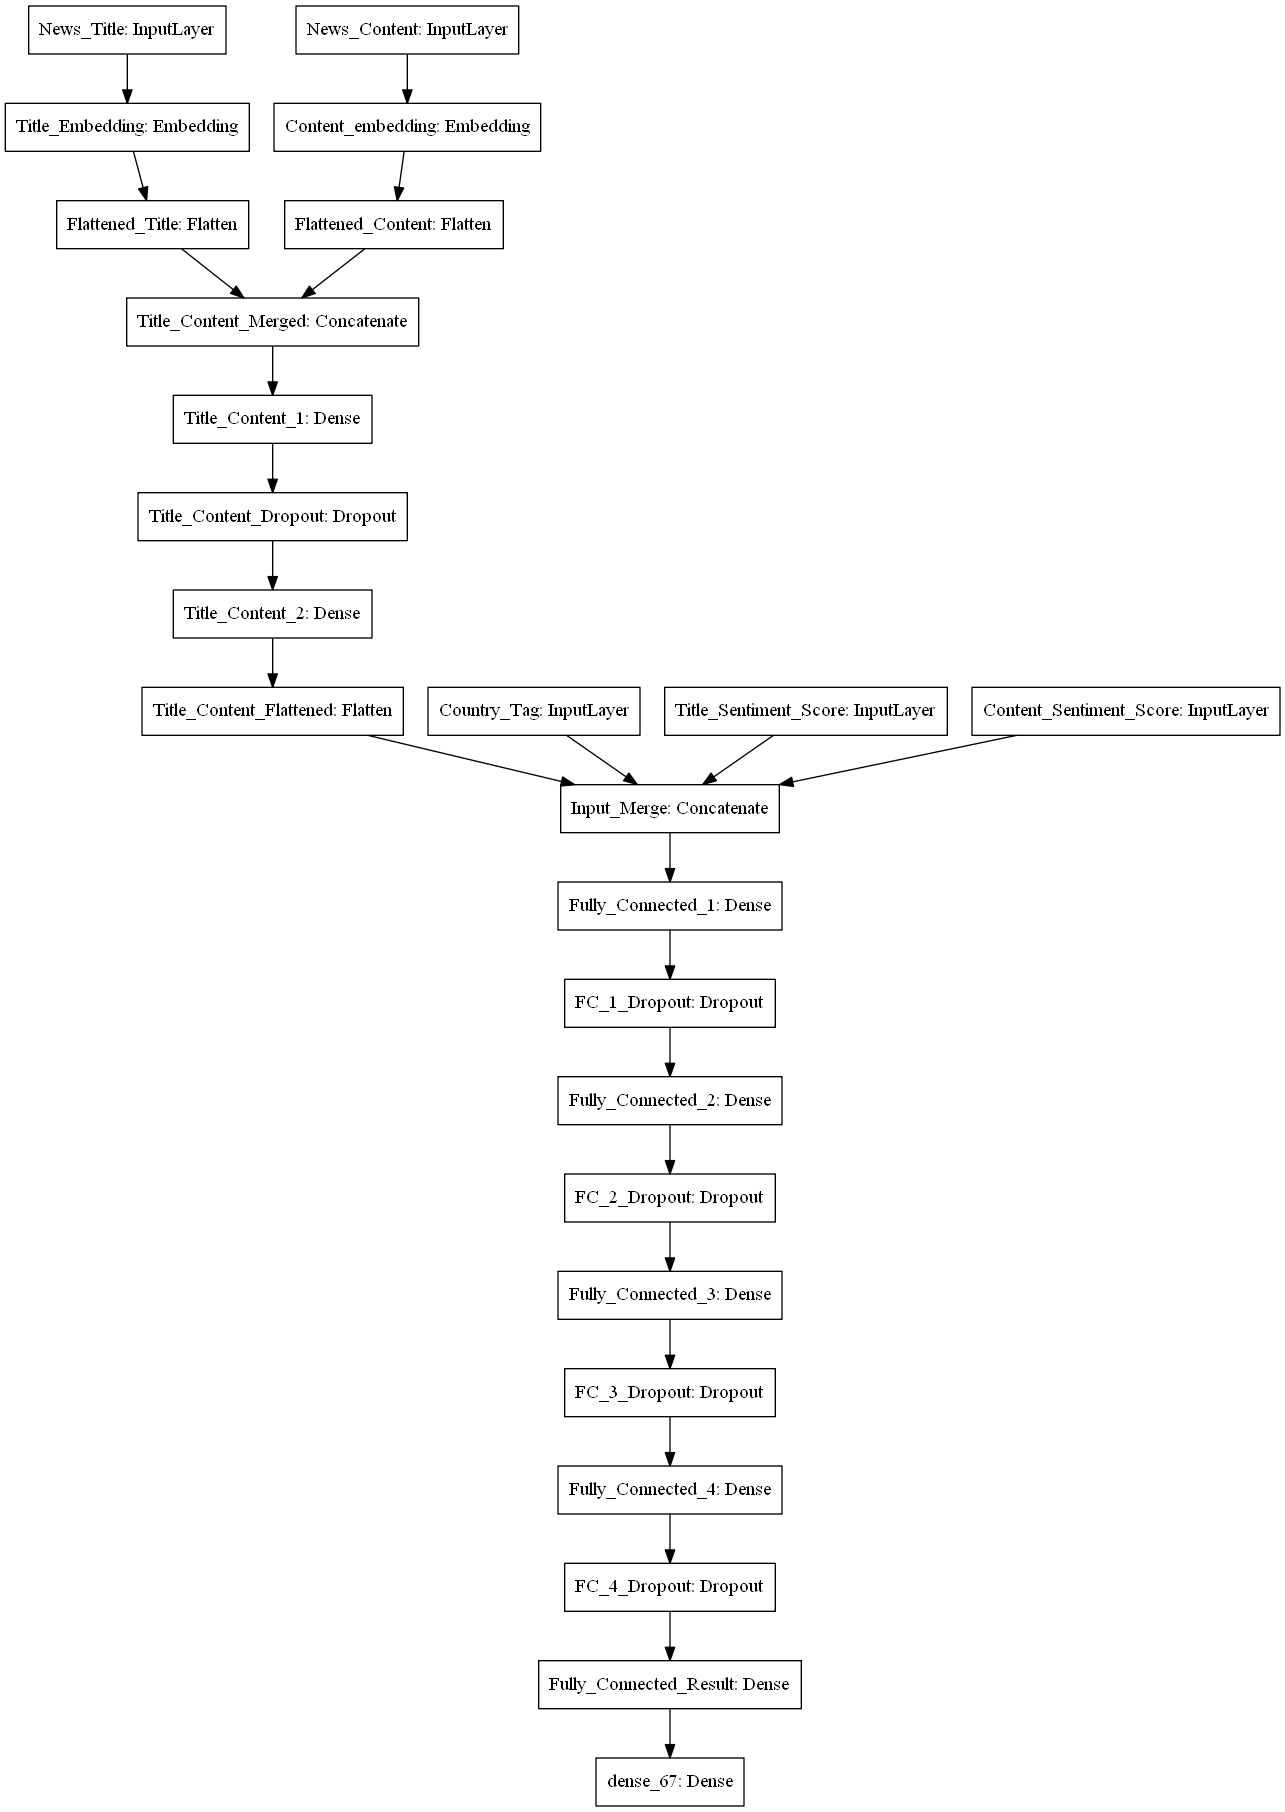

In [218]:
plot_model(model)

In [219]:
model.compile(optimizer=Adam(lr=0.01),
              loss='mse', 
              metrics=['accuracy'])

### Train The Model

In [220]:
history = model.fit([data.country_codes, title_padded_sequence, content_padded_sequence, data.title_score, data.content_score], azernews.support_class, validation_split=0.2, epochs=60, batch_size=64,  callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)])

Train on 176 samples, validate on 44 samples
Epoch 1/250
176/176 [==============================] - 4s 22ms/sample - loss: 0.8525 - acc: 0.4091 - val_loss: 1.1954 - val_acc: 0.0000e+00
Epoch 2/250
176/176 [==============================] - 3s 16ms/sample - loss: 0.9124 - acc: 0.4034 - val_loss: 1.1571 - val_acc: 0.0000e+00
Epoch 3/250
176/176 [==============================] - 3s 15ms/sample - loss: 0.9185 - acc: 0.4205 - val_loss: 2.2727 - val_acc: 0.4318
Epoch 4/250
176/176 [==============================] - 3s 18ms/sample - loss: 0.8494 - acc: 0.3580 - val_loss: 2.2727 - val_acc: 0.4318
Epoch 5/250
176/176 [==============================] - 3s 17ms/sample - loss: 0.9339 - acc: 0.3295 - val_loss: 2.2727 - val_acc: 0.4318
Epoch 6/250
176/176 [==============================] - 3s 16ms/sample - loss: 0.9984 - acc: 0.3864 - val_loss: 2.2727 - val_acc: 0.4318
Epoch 7/250
176/176 [==============================] - 3s 16ms/sample - loss: 0.9138 - acc: 0.4091 - val_loss: 2.2727 - val_acc: 0.

KeyboardInterrupt: 